In [1]:
import statsmodels.api as sm
from Chemometrics.import_common import *
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# 读取数据
iron_peaks = pload('QC_sample.p')
# 进样序号
iron_peaks = pload('QC_sample.p').drop('QCgrp',axis=1)
# 缺失值处理
iron_peaks.isnull().values.flatten().any()

True

---

# 峰面积的校正
<br>
利用QC样本的进样序号回归峰面积。  
以分析物1为例

In [3]:
# 读取数据
ana = pload('QC_sample.p')
ana1 = ana.loc[ana.loc[:,'Component Name']==1,:]
ana1_QC = ana1[ana1.loc[:,'Sample Name'] == 'QC']
ana1_QC = ana1_QC.set_index('Injection Order')['Area']
ana1_sample = ana1[ana1.loc[:,'Sample Name'] != 'QC']
ana1_sample = ana1_sample.set_index('Injection Order')['Area']
ana1_all = ana1.set_index('Injection Order')['Area']

## loess：Local Regression 

In [4]:
# QC样品 loess 拟合
lowess = sm.nonparametric.lowess
fits_= lowess(ana1_QC,ana1_QC.index, frac=1./2,return_sorted =False)

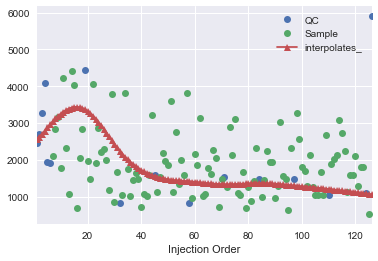

In [5]:
# QC loess 拟合并插值
from scipy import interpolate
f = interpolate.interp1d(ana1_QC.index,fits_,kind='cubic')# 用拟合出的QC强度的插值
ana1_interpolate = f(ana1_all.index)
#plt.plot(ana1.index,fits_,'o',label='loess fitted')
ana1_QC.plot(style='o',label='QC')
ana1_sample.plot(style='o',label='Sample')
plt.plot(ana1_all.index,ana1_interpolate,'^-',label='interpolates_')
plt.legend()

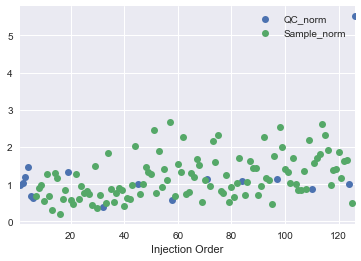

In [6]:
# normalization QC样品 
norm_ = ana1_all/ana1_interpolate
QC_norm = norm_[ana1_QC.index]
QC_norm.plot(style='o',label='QC_norm')
# normalize 其他样本
# 1. 插值法(3次样条)求出其他进样序号下QC的强度
# 2. 样本测试强度/插值QC强度
sample_norm = norm_[ana1_sample.index]
sample_norm.plot(style='o',label='Sample_norm')
plt.legend()

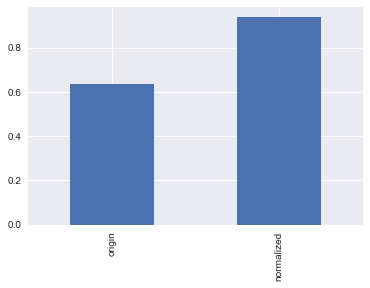

In [7]:
# normlize 评价
RSD = lambda x:x.std()/x.mean()
RSD_origin = RSD(ana1_QC)
RSD_norm = RSD(QC_norm)
RSDs = pd.Series([RSD_origin,RSD_norm],index=['origin','normalized'])
RSDs.plot.bar()

origin        0.637604
normalized    0.376384
dtype: float64

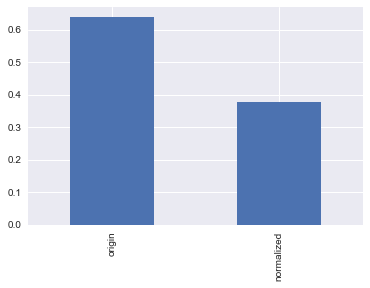

In [144]:
#去掉异常点
RSD = lambda x:x.std()/x.mean()
RSD_origin = RSD(ana1_QC)
RSD_norm = RSD(QC_norm[1:-2])
RSDs = pd.Series([RSD_origin,RSD_norm],index=['origin','normalized'])
RSDs.plot.bar()
RSDs

# SVR
todo

In [83]:
from sklearn.svm import SVR,LinearSVR

In [53]:
ana_ = ana.set_index('Injection Order').drop(['QCgrp','Sample Name'],axis=1).pivot(columns='Component Name',values='Area')

In [56]:
QC = ana_.loc[ana1_QC.index]

In [61]:
# 相关性前五的组分
cor5 = QC.corr()[1].sort_values(ascending=False).iloc[1:6].index
X_all = ana_.loc[:,cor5].dropna(axis=0)# 缺失值处理
X_QC = X_all.loc[X_all.index.isin(QC.index)]
ana1_QC_ = ana1_all[X_QC.index]

In [99]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([('prep',StandardScaler()),('svr',SVR())])

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import LeaveOneOut

In [131]:
param_grid_ = {'svr__C':[.1,1,10,100,1000,10000],
              'svr__gamma':[1e-5,0.001,.01,.1,1]}

In [132]:
grid = GridSearchCV(pipe,param_grid=param_grid_)

In [133]:
grid.fit(X_QC,ana1_QC_)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('prep', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svr__C': [0.1, 1, 10, 100, 1000, 10000], 'svr__gamma': [1e-05, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [135]:
grid.score(X_QC,ana1_QC_)

0.469377767868581

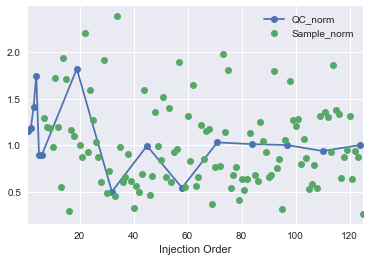

In [138]:
ana1_svr = grid.predict(X_all)
norm_ = ana1_all[X_all.index]/ana1_svr
QC_norm = norm_[X_QC.index]
QC_norm.plot(style='-o',label='QC_norm')
sample_norm = norm_.loc[~X_all.index.isin(X_QC.index)]
sample_norm.plot(style='o',label='Sample_norm')
plt.legend()

origin        0.554397
normalized    0.339990
dtype: float64

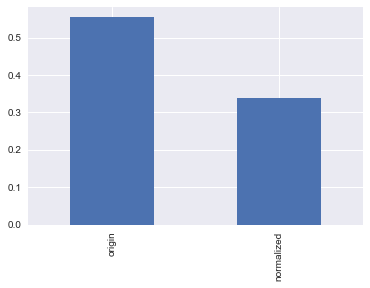

In [146]:
RSD_origin = RSD(ana1_QC_)
RSD_norm = RSD(QC_norm)
RSDs_ = pd.Series([RSD_origin,RSD_norm],index=['origin','normalized'])
RSDs_.plot.bar()
RSDs_